In [1]:
from muler.igrins import IGRINSSpectrum
from muler.hpf import HPFSpectrum

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

import glob
import os
import warnings

import astropy.units as u
# from astropy.io import ascii
# from astropy.io import fits
# from astropy.table import Table, Column, join
# from astropy.wcs import WCS
from astropy.modeling import models, fitting

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_continuum, fit_lines, find_lines_threshold
from specutils.analysis import equivalent_width
from specutils.manipulation import noise_region_uncertainty

from scipy.integrate import trapz
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False

In [2]:
# path = 'A:/Documents/Grad_School/Research/igrins_reduced/20161101/'
# filename = 'SDCK_20161101_0062.spec_a0v.fits'
# spec = IGRINSSpectrum(file=path+filename)

# Reduced data in txt files
data_path = "A:/Documents/Grad_School/Research/IGRINS_Merged/"
# File path for figures to live in
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"merged_standards/m*.txt")

# NIR Lines in micron
nir_dict = {
    "Fe-2.084": 2.084,
    "Si-2.092"	:	2.092,
    "Mg-2.106"	:	2.106,
    "Al-2.11"	:	2.11,
    "Ca-2.2035"	:	2.2035,
    "Fe-2.2037"	:	2.2037,
    "Sc-2.2052"	:	2.2052,
    "Na-2.2052"	:	2.2052,
    "Si-2.2063"	:	2.2063,
    "Sc-2.2065"	:	2.2065,
    "Si-2.2073"	:	2.2073,
    "Fe-2.2079"	:	2.2079,
    "Na-2.2083"	:	2.2083,
    "Ca-2.2113"	:	2.2113,
    "Br-Gamma"  :   2.1655,
    "Ti-2.2218"	:	2.2218,
    "Ti-2.224"	:	2.224,
    "Fe-2.226"	:	2.226,
    "Ti-2.228"	:	2.228,
    "Ti-2.232"	:	2.232,
    "Ca-2.26573"	:	2.26573,
    "Fe-2.2742"	:	2.2742,
    "Mg-2.281"	:	2.281,
    "Ca-2.2825"	:	2.2825,
    "Fe-2.284"	:	2.284,
    "Ti-2.29"	:	2.29,
    "Ti-2.297"	:	2.297
}
    # "CO(2-0)-2.29353" :	2.29353,
    # "CO(2-0)-2.32265"	:	2.32265,
    # "CO(2-0)-2.34327" :	2.34327,
    # "CO(2-0)-2.34531" :	2.34531,
    # "CO(2-0)-2.3495" 	:	2.3495,
    # "CO(2-0)-2.35167"	:	2.35167,
    # "CO(2-0)-2.35246" :	2.35246,
    # "CO(2-0)-2.38295" :	2.38295,
    # }

# Strings of the Nir lines
lines_str = list(nir_dict.keys())

# Wavelength values for each NIR line
lines_wav = list(nir_dict.values())

# Just a list of the elemental shorthand symbols
labels = [string.split('-')[0] for string in lines_str]

In [3]:
# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

In [4]:
merged_standard_files

['A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mAnon1_M05.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mHBC427_K6.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mHubble4_K8.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mJH108_M15.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa14_K5.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa1_M4.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa4_M2.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mV410-Xray5a_M6.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mV830Tau_K75.txt']

In [5]:
# Pandas Column IDs
igrins_cols = ['Wavelength', 'Flux', 'SNR','zero']

# Anon 1
anon1_df = pd.read_csv(merged_standard_files[0], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is an object for some reason, change to float
anon1_df['SNR'] = anon1_df['SNR'].astype(float)

# No negative flux and require SNR > 5
#  & (anon1_df['SNR'] < 10000)
#  & (anon1_df['Flux'] .gt( 0.4e6))
anon1_df = anon1_df[(anon1_df['Wavelength'].gt(2.)) & (anon1_df['SNR'].between(100,10000))] 

# Wavelength + Flux Arrays
anon1_wavlen = anon1_df['Wavelength']
anon1_flux = anon1_df['Flux']

In [6]:
anon1_df

,Wavelength,Flux,SNR,zero
10423,2.00002,1109730.0,3410.7444,0.0
10424,2.00003,1092810.0,3382.3284,0.0
10425,2.00004,1084850.0,3370.7534,0.0
10426,2.00006,1087490.0,3415.9021,0.0
10427,2.00007,1078210.0,3454.6165,0.0
...,...,...,...,...
42877,2.48233,552474.0,9367.6182,0.0
42878,2.48234,542871.0,9297.8857,0.0
42879,2.48236,584677.0,9789.9443,0.0
42880,2.48237,524094.0,9594.8896,0.0


In [7]:
anon1_df[anon1_df['Wavelength'].gt(2.2)]

,Wavelength,Flux,SNR,zero
24749,2.20001,938443.0,2343.8047,0.0
24750,2.20002,941676.0,2303.5410,0.0
24751,2.20004,939139.0,2284.6096,0.0
24752,2.20005,940729.0,2308.1523,0.0
24753,2.20007,947602.0,2348.2058,0.0
...,...,...,...,...
42877,2.48233,552474.0,9367.6182,0.0
42878,2.48234,542871.0,9297.8857,0.0
42879,2.48236,584677.0,9789.9443,0.0
42880,2.48237,524094.0,9594.8896,0.0


# Ti-2.224
I can make the cell below better and make more sense

In [8]:
# Central anon1_wavlenlength (micron)
wave_center = 2.224

center_idx = (anon1_wavlen-wave_center).abs().idxmin()
# Size of 1 spectral resolution element
# micron per pixel
spec_res = 0.00001

# Define the edges of the feature along spectral axis (NOT FLUX)
wave_lim1 = wave_center - (50*spec_res)
wave_lim2 = wave_center + (50*spec_res)

# Find the indices for the min and max wavelengths of the spectral feature 
wavemin_idx = (anon1_wavlen-wave_lim1).abs().idxmin()
wavemax_idx = (anon1_wavlen-wave_lim2).abs().idxmin()

# # Choose spectral regions on either side of spectral feature to define a continuum
contlo_1 = wave_lim1-(125*spec_res)
contlo_2 = wave_lim1

conthi_1 = wave_lim2
conthi_2 = wave_lim2+(125*spec_res)

# # Find the indices for the continuum regions on either side of the spectral feature
contlo_min = (anon1_wavlen - contlo_1).abs().idxmin()
contlo_max = (anon1_wavlen - contlo_2).abs().idxmin()

conthi_min = (anon1_wavlen - conthi_1).abs().idxmin()
conthi_max = (anon1_wavlen - conthi_2).abs().idxmin()

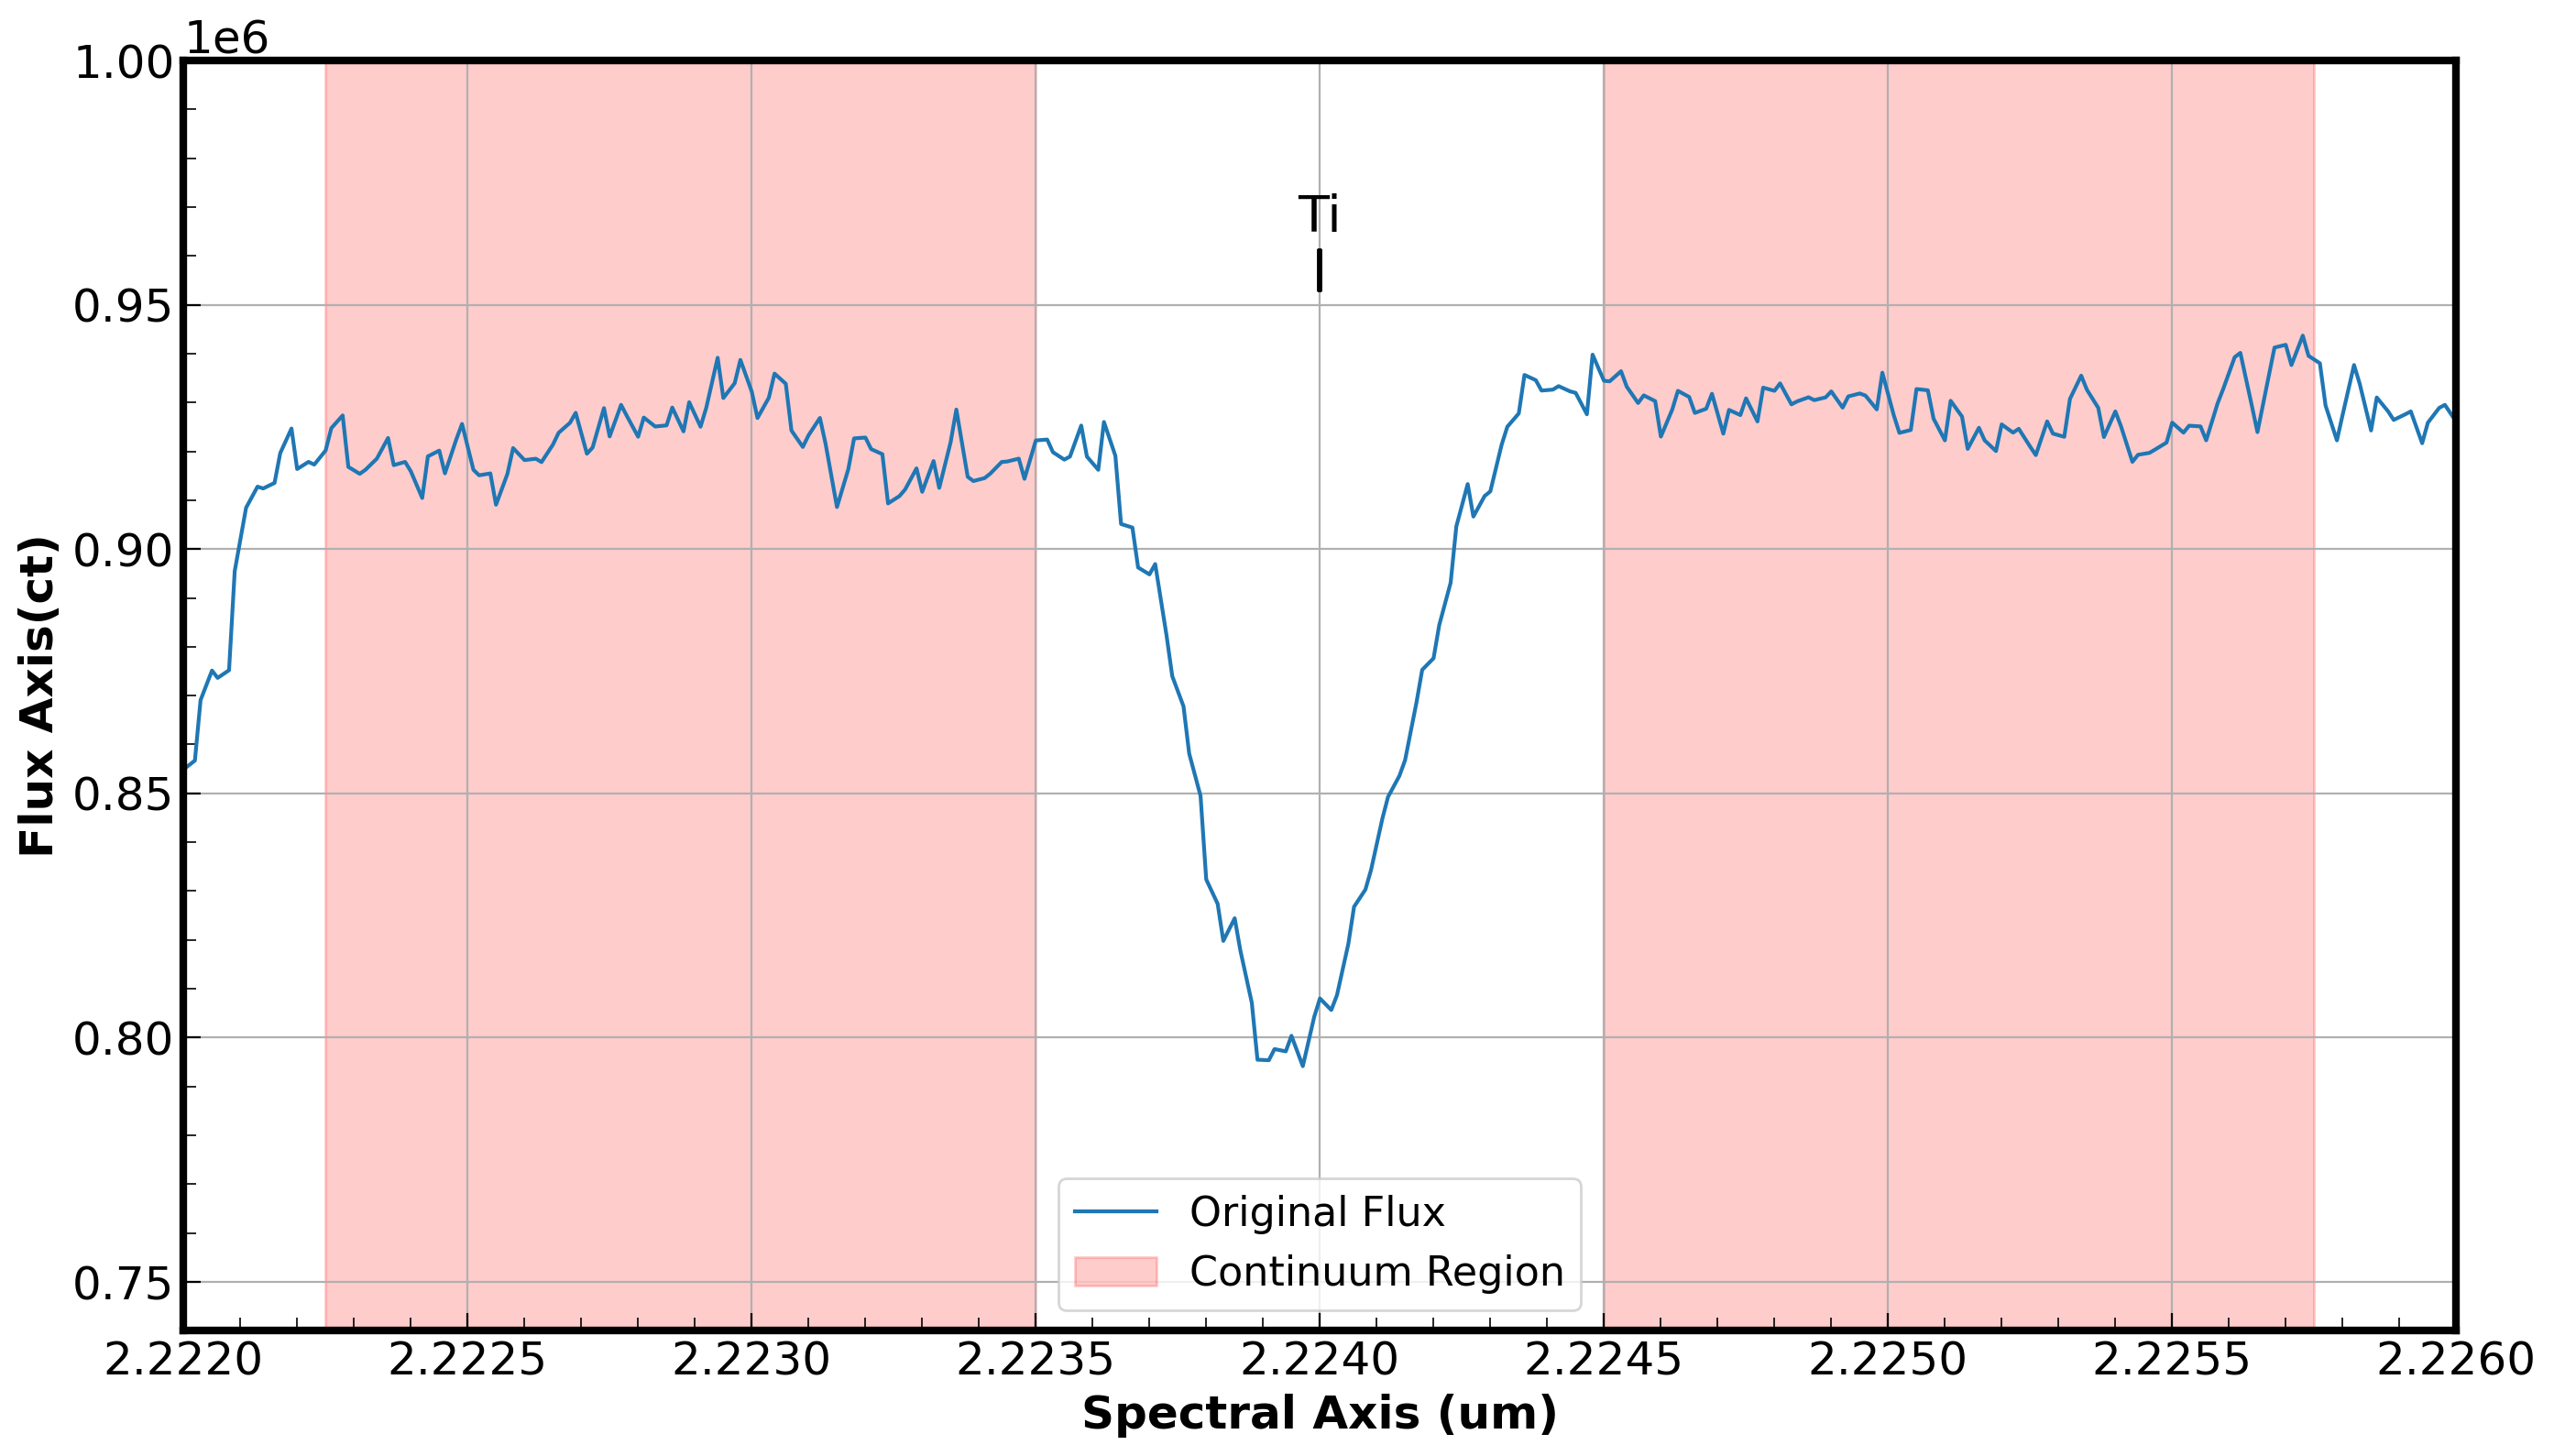

In [9]:
# Make 1D Spectrum Object
anon1_spec = Spectrum1D(spectral_axis=anon1_wavlen.values*u.um,flux=anon1_flux.values*u.ct)
fig,ax = plt.subplots(figsize=(16,9))

plt.plot(anon1_spec.spectral_axis, anon1_spec.flux, label='Original Flux')
# plt.plot(anon1_spec.spectral_axis, anon1_cont)

# Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
# Iterate over number of objects
for i in range(len(nir_dict)):
    # Iterate over the NIR dictionary
    for ii in range(len(lines_wav)):
        plt.axvline(lines_wav[ii],0.82,0.85,color='black')
    # ax.text(lines_wav[ii],text_y,labels,ha='center')


plt.axvspan(contlo_1,contlo_2, color='red', alpha=0.2,label='Continuum Region')
plt.axvspan(conthi_1,conthi_2, color='red', alpha=0.2)

text_y = 0.965e6
# ax.text(nir_dict['Ti-2.2218'],text_y,'Ti',ha='center')
ax.text(nir_dict['Ti-2.224'],text_y,'Ti',ha='center')
# ax.text(nir_dict['Fe-2.226'],text_y,'Fe',ha='center')
# ax.text(nir_dict['Ti-2.228'],text_y,'Ti',ha='center')
# ax.text(nir_dict['Ti-2.232'],text_y,'Ti',ha='center')

# Set fig axis limits
plt.xlim(2.222,2.226)
plt.ylim(0.74e6,1e6)

# Enable minor tick marks
ax.minorticks_on()

plt.xlabel('Spectral Axis ({})'.format(anon1_spec.spectral_axis.unit)) 
plt.ylabel('Flux Axis({})'.format(anon1_spec.flux.unit)) 
ax.grid()
plt.legend()
plt.show()

# Local Continuum Fitting

In [10]:
# estimate continuum using mean of points in selected range
# wavelength range of where I'm estimating continuum
contlo_wave = anon1_wavlen.loc[contlo_min:contlo_max]
conthi_wave = anon1_wavlen.loc[conthi_min:conthi_max]

# fluxe range of where I'm estimating continuum
contlo_flux = anon1_flux.loc[contlo_min:contlo_max]
conthi_flux = anon1_flux.loc[conthi_min:conthi_max]

contwave_array = np.concatenate((contlo_wave, conthi_wave))
contflux_array = np.concatenate((contlo_flux, conthi_flux))

mean_cont = np.sum(contflux_array)/len(contflux_array)

# estimate continuum using 1d polyfit to points in selected range
cont_fit = np.polyfit(contwave_array, contflux_array, 1)
fitval = np.poly1d(cont_fit)
continuum = fitval(anon1_wavlen)

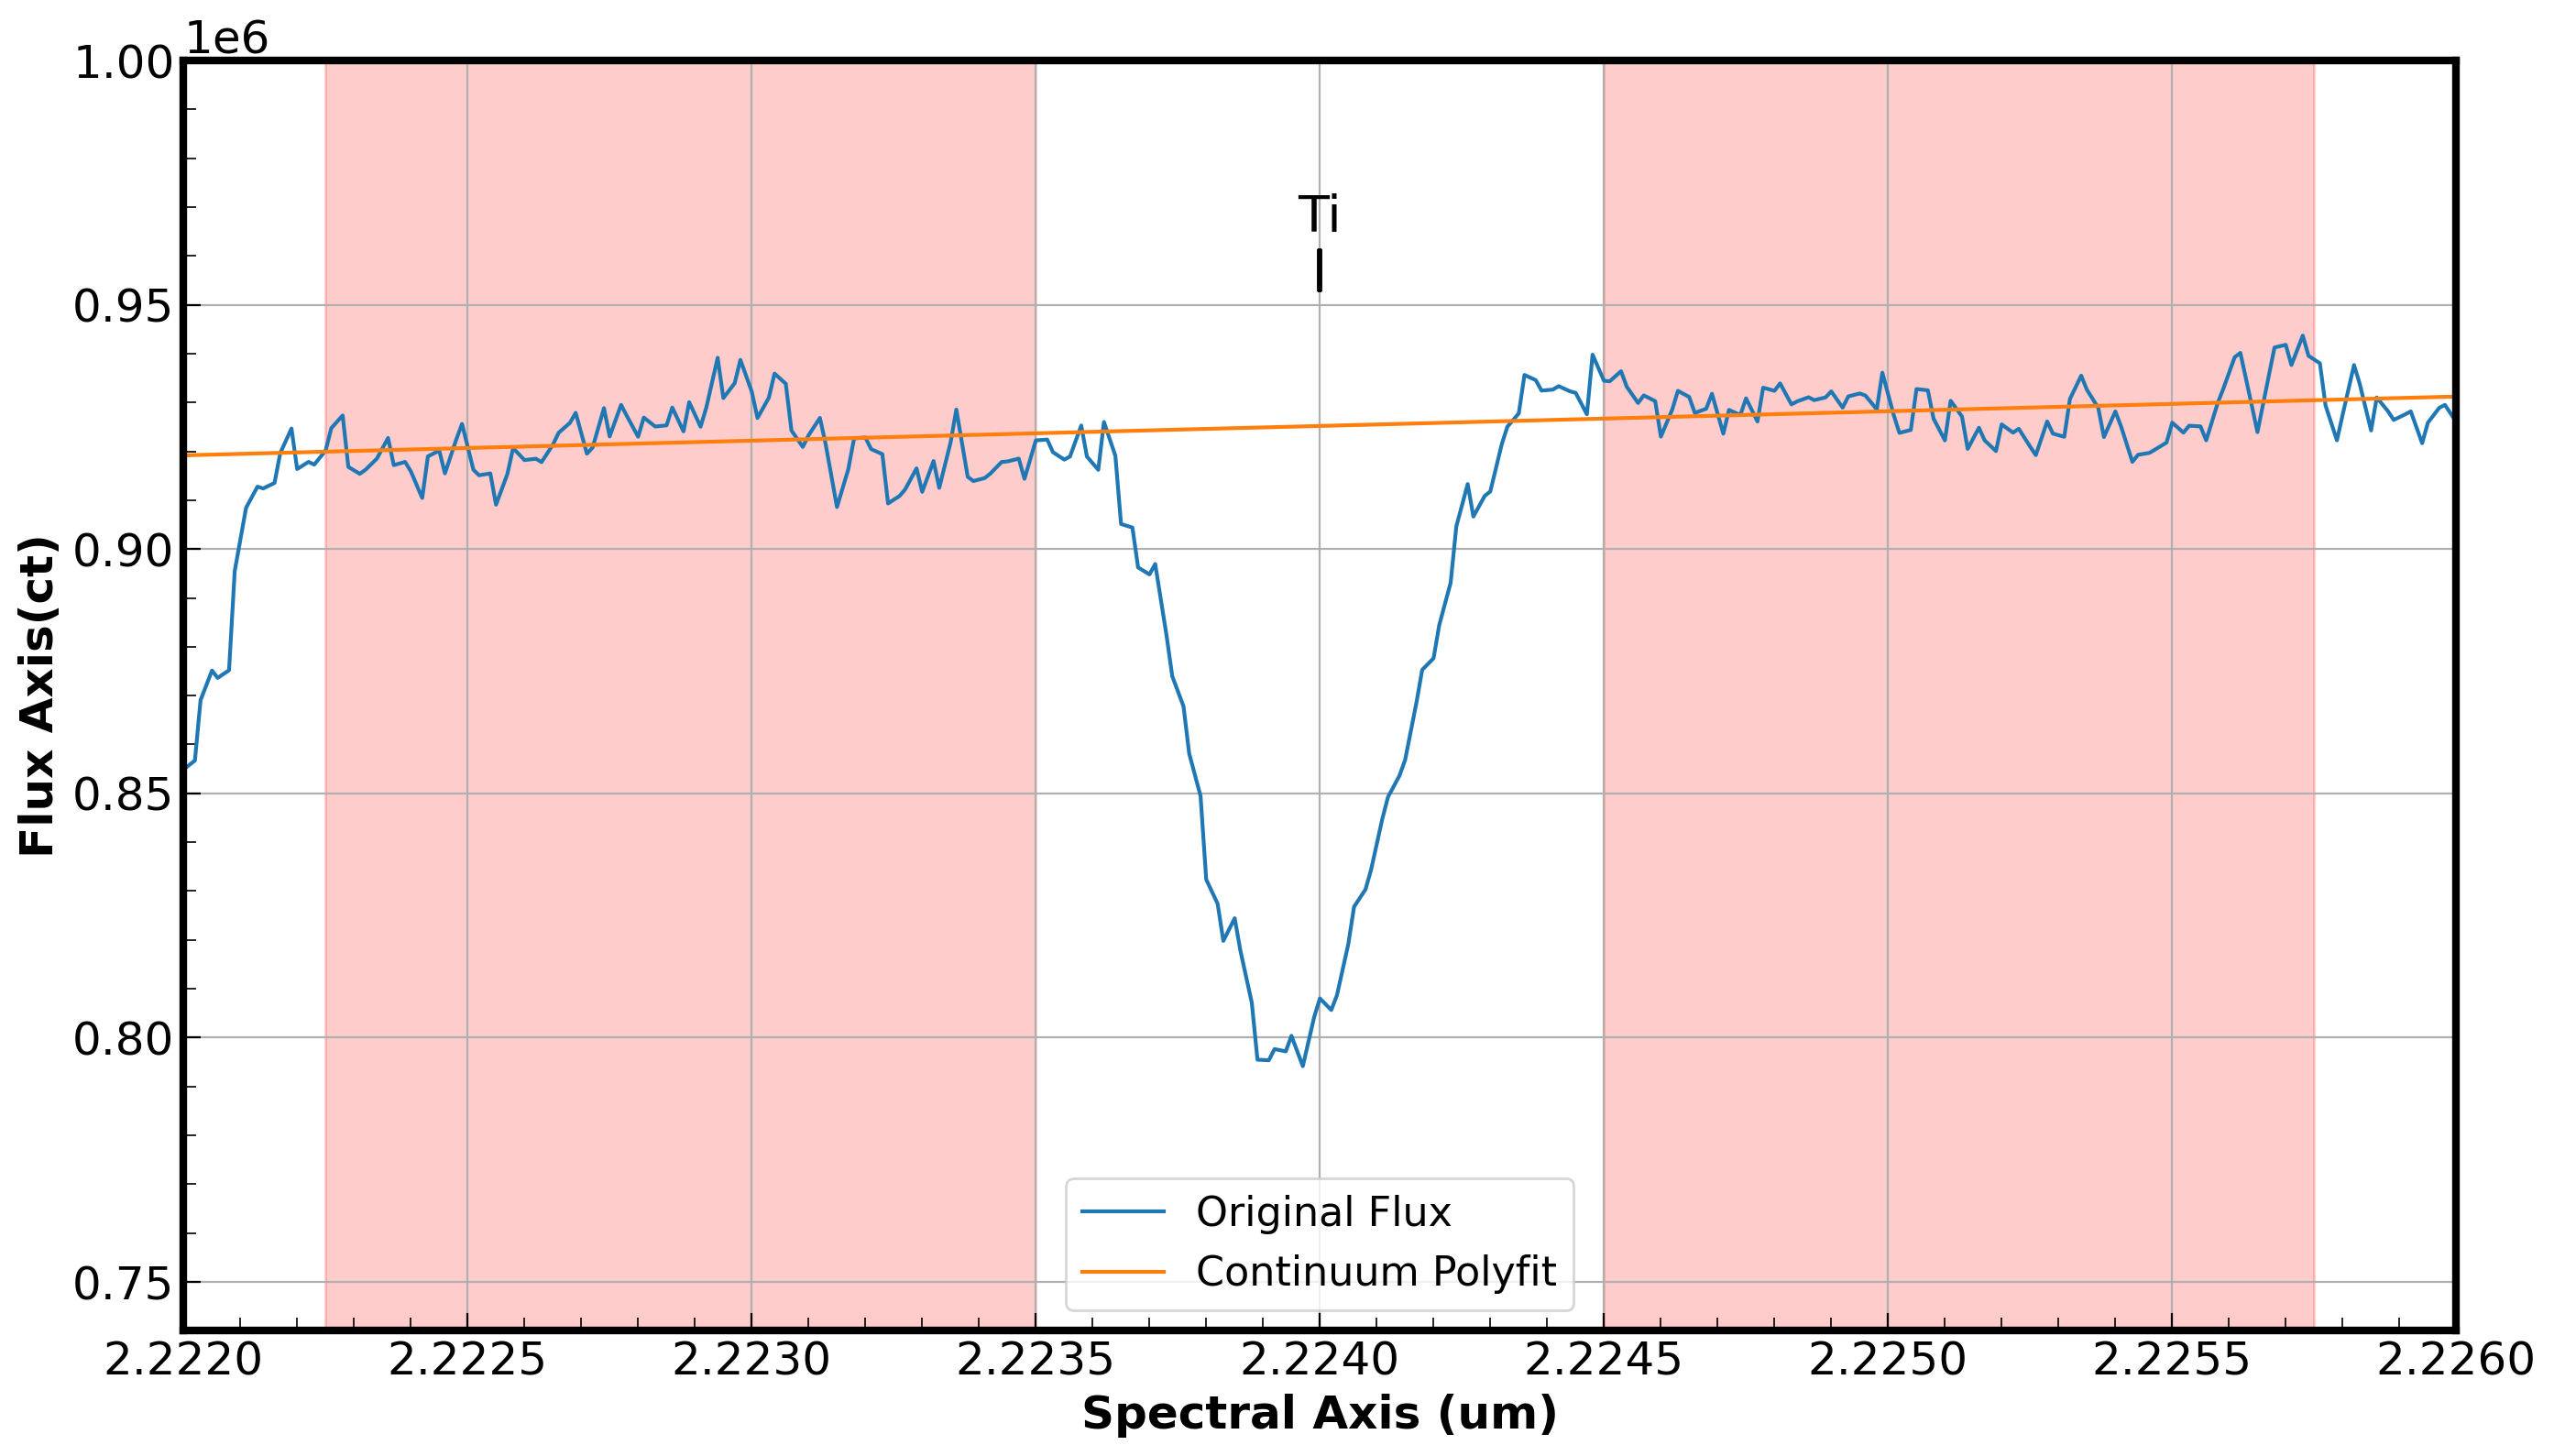

In [11]:
fig,ax = plt.subplots(figsize=(16,9))

plt.plot(anon1_spec.spectral_axis, anon1_spec.flux, label='Original Flux')
plt.plot(anon1_spec.spectral_axis, continuum,label='Continuum Polyfit')

# Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
# Iterate over number of objects
for i in range(len(nir_dict)):
    # Iterate over the NIR dictionary
    for ii in range(len(lines_wav)):
        plt.axvline(lines_wav[ii],0.82,0.85,color='black')
    # ax.text(lines_wav[ii],text_y,labels,ha='center')


plt.axvspan(contlo_1,contlo_2, color='red', alpha=0.2)
plt.axvspan(conthi_1,conthi_2, color='red', alpha=0.2)

text_y = 0.965e6
# ax.text(nir_dict['Ti-2.2218'],text_y,'Ti',ha='center')
ax.text(nir_dict['Ti-2.224'],text_y,'Ti',ha='center')
# ax.text(nir_dict['Fe-2.226'],text_y,'Fe',ha='center')
# ax.text(nir_dict['Ti-2.228'],text_y,'Ti',ha='center')
# ax.text(nir_dict['Ti-2.232'],text_y,'Ti',ha='center')

# Set fig axis limits
plt.xlim(2.222,2.226)
plt.ylim(0.74e6,1e6)

# Enable minor tick marks
ax.minorticks_on()

plt.xlabel('Spectral Axis ({})'.format(anon1_spec.spectral_axis.unit)) 
plt.ylabel('Flux Axis({})'.format(anon1_spec.flux.unit)) 
ax.grid()
plt.legend()
plt.show()

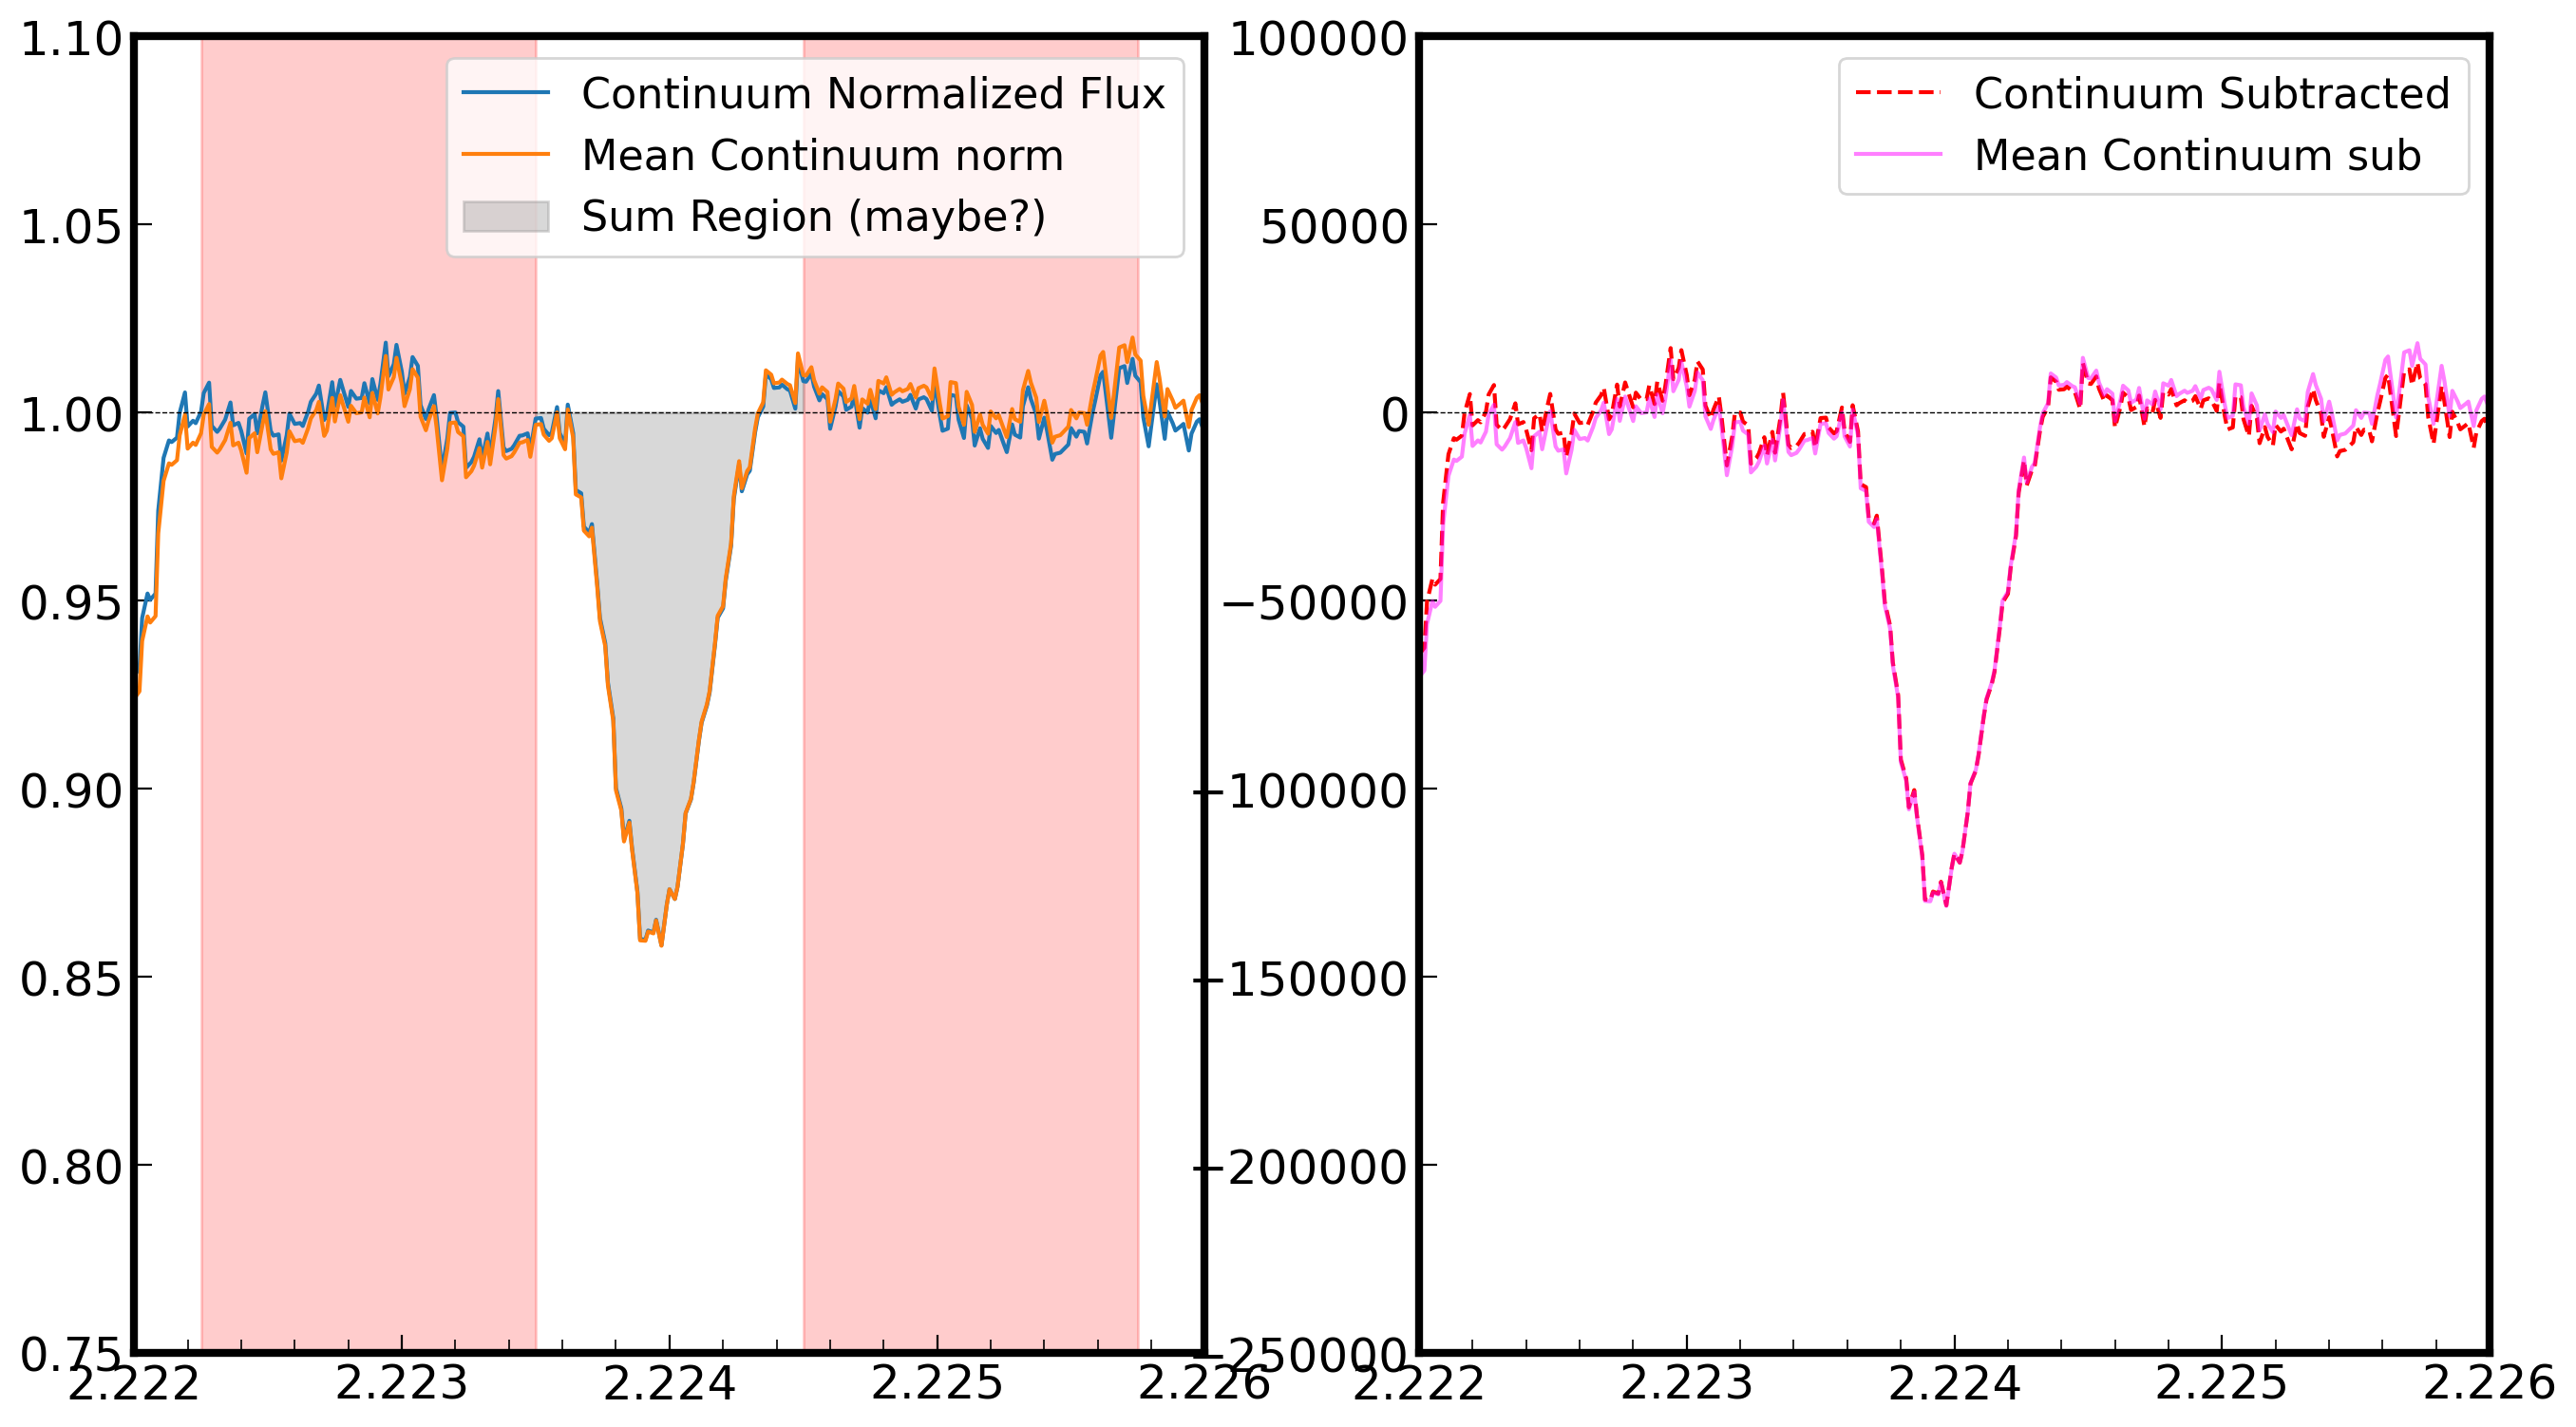

In [12]:
#examine the continuum-modified spectra

cont_sub = anon1_flux-continuum # the polyfit continuum-subtracted flux
cont_norm = anon1_flux/continuum # polyfit continuum normalized flux

meancont_sub = anon1_flux-mean_cont # the mean continuum-subtracted flux
meancont_norm = anon1_flux/mean_cont # mean continuum normalized flux


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,9))
plt.subplot(121)
# plt.plot(anon1_wavlen, anon1_flux,label='Original Flux')
# plt.plot(anon1_wavlen, continuum,label='Continuum')

plt.plot(anon1_wavlen, cont_norm,label='Continuum Normalized Flux')
plt.plot(anon1_wavlen, meancont_norm,label='Mean Continuum norm')

# plt.plot(anon1_wavlen, cont_sub, color='red', linestyle='dashed',label='Poly fit subtracted')
# plt.plot(anon1_wavlen, meancont_sub, color='magenta',label='Mean Continuum subtracted')

# ax1.set_yscale('log')

plt.xlim(2.222,2.226)
plt.ylim(.75,1.1)

plt.axvspan(contlo_1,contlo_2, color='red', alpha=0.2)
plt.axvspan(conthi_1,conthi_2, color='red', alpha=0.2)

plt.axhline(y=1, color='black', linewidth=0.5, linestyle='dashed')

plt.fill_between(anon1_wavlen, y1=cont_norm,y2=1.0, where=(anon1_wavlen >= contlo_2) & (anon1_wavlen <= conthi_1), color='gray', alpha=0.3, label='Sum Region (maybe?)')

plt.legend()

plt.subplot(122)
plt.plot(anon1_wavlen, cont_sub, color='red', linestyle='dashed', label='Continuum Subtracted')
plt.plot(anon1_wavlen, meancont_sub, color='magenta', alpha=0.5, label='Mean Continuum sub')
plt.legend()

plt.xlim(2.222,2.226)
plt.ylim(-0.25e6,.1e6)

plt.axhline(y=0, color='black', linewidth=0.5, linestyle='dashed')

ax.minorticks_on()
plt.savefig(fig_path+'anon1_Ti_2_224.png')
plt.show()
#plt.scatter(4.18,4.75, color='magenta', marker='o', s=25)
#plt.scatter(4.18,4.5, color='red', marker='o', s=25)

#plt.text(4.181,4.7, s="= mean continuum", color='magenta', fontsize=14)
#plt.text(4.181,4.45, s="= fit continuum", color='red', fontsize=14)

# Gaussian Fitting

In [13]:
# Use Normalized Gaussian Distribution
def gaussian_func(x,ampl,center,std,b):
    return ((ampl)/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*(x - center)**2 / (std**2))) + b

# Find the indices for the min and max wavelengths of the spectral feature 
linemin_idx = (anon1_wavlen-wave_lim1).abs().idxmin()
linemax_idx = (anon1_wavlen-wave_lim2).abs().idxmin()

wavemin = anon1_wavlen[linemin_idx]
wavemax = anon1_wavlen[linemax_idx]

In [14]:
def interact_gauss():
    from ipywidgets import interact, FloatSlider
    from IPython.display import display
    
    ## Set up the plot data
    x     = anon1_wavlen # Wavelength data
    fig   = plt.figure()
    plt.plot(anon1_wavlen, cont_norm, color='black',label=r"Original Spectrum") # This includes the original spectrum in the figure
    line, = plt.plot([], [], color='orangered', linewidth=4, label=r"Test Gaussian") # Initialize curve to empty data.
    
    ## Scale Bar Parameters, Minimum, Maximum, Step Size, and Starting Position
    ampl_min, ampl_max, ampl_step, ampl_init = -2., 2., 0.01, 0.0
    cent_min, cent_max, cent_step, cent_init = min(anon1_wavlen), max(anon1_wavlen), 0.001, wave_center
    std_min, std_max, std_step, std_init = 0.1, 100, 0.1, 1.0
    b_min, b_max, b_step, b_init = 0.0, 1.5, 0.05, 1.

    ## Set up the figure axes, etc.
    # plt.xlim(0.9*min(wave), 1.05*max(wave)) # Use data to determine bounds
    # plt.ylim(0.9*min(intensity), 1.1*max(intensity)) # Use data to determine bounds
    plt.xlim(2.222,2.226)
    plt.ylim(0.8,1.15)
    
    plt.xlabel(r'Wavelength',fontsize=34)
    plt.ylabel(r'Intensity',fontsize=34)
    plt.legend(loc="upper left",fontsize=16)
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_gauss(Amplitude,Center,Width,b):
        y = gaussian_func(x,Amplitude,Center,Width,b) # Test Gaussian Data
        line.set_data(x, y) # Add Wavelength and Gaussian Data
        ax.relim()  # Recalculate limits
        ax.autoscale_view()  # Autoscale the vie
        display(fig)

    ## Generate the user interface.
    interact(
        plot_gauss, Amplitude=FloatSlider(min=ampl_min, max=ampl_max, step=ampl_step, value=ampl_init), Center=FloatSlider(min=cent_min, max=cent_max, step=cent_step, value=cent_init), Width=FloatSlider(min=std_min, max=std_max, step=std_step, value=std_init), b=FloatSlider(min=b_min, max=b_max, step=b_step, value=b_init)
        )
# interact_gauss()

In [15]:
# initial guesses, need 4 inputs: Amplitude, mean, std_dev, b (y offset)
init_params = -1.,  wave_center, .01, anon1_wavlen.loc[wavemin_idx:wavemax_idx].min()
# Bounds on the parameters
bounds = ([-10.,0.,0.01,0.95],[10,200.,100.,1.05])

In [16]:
popt, pcov = curve_fit(f=gaussian_func, xdata=anon1_wavlen.loc[contlo_min:conthi_max], ydata=cont_norm.loc[contlo_min:conthi_max],p0=init_params, maxfev=10000)
best_model = gaussian_func(anon1_wavlen, *popt)

print("Best Fit Parameters:", popt)

Best Fit Parameters: [-5.58531104e-05  2.22395640e+00  1.56238053e-04  1.00068371e+00]


In [17]:
anon1_wavlen[contlo_max]

2.2235

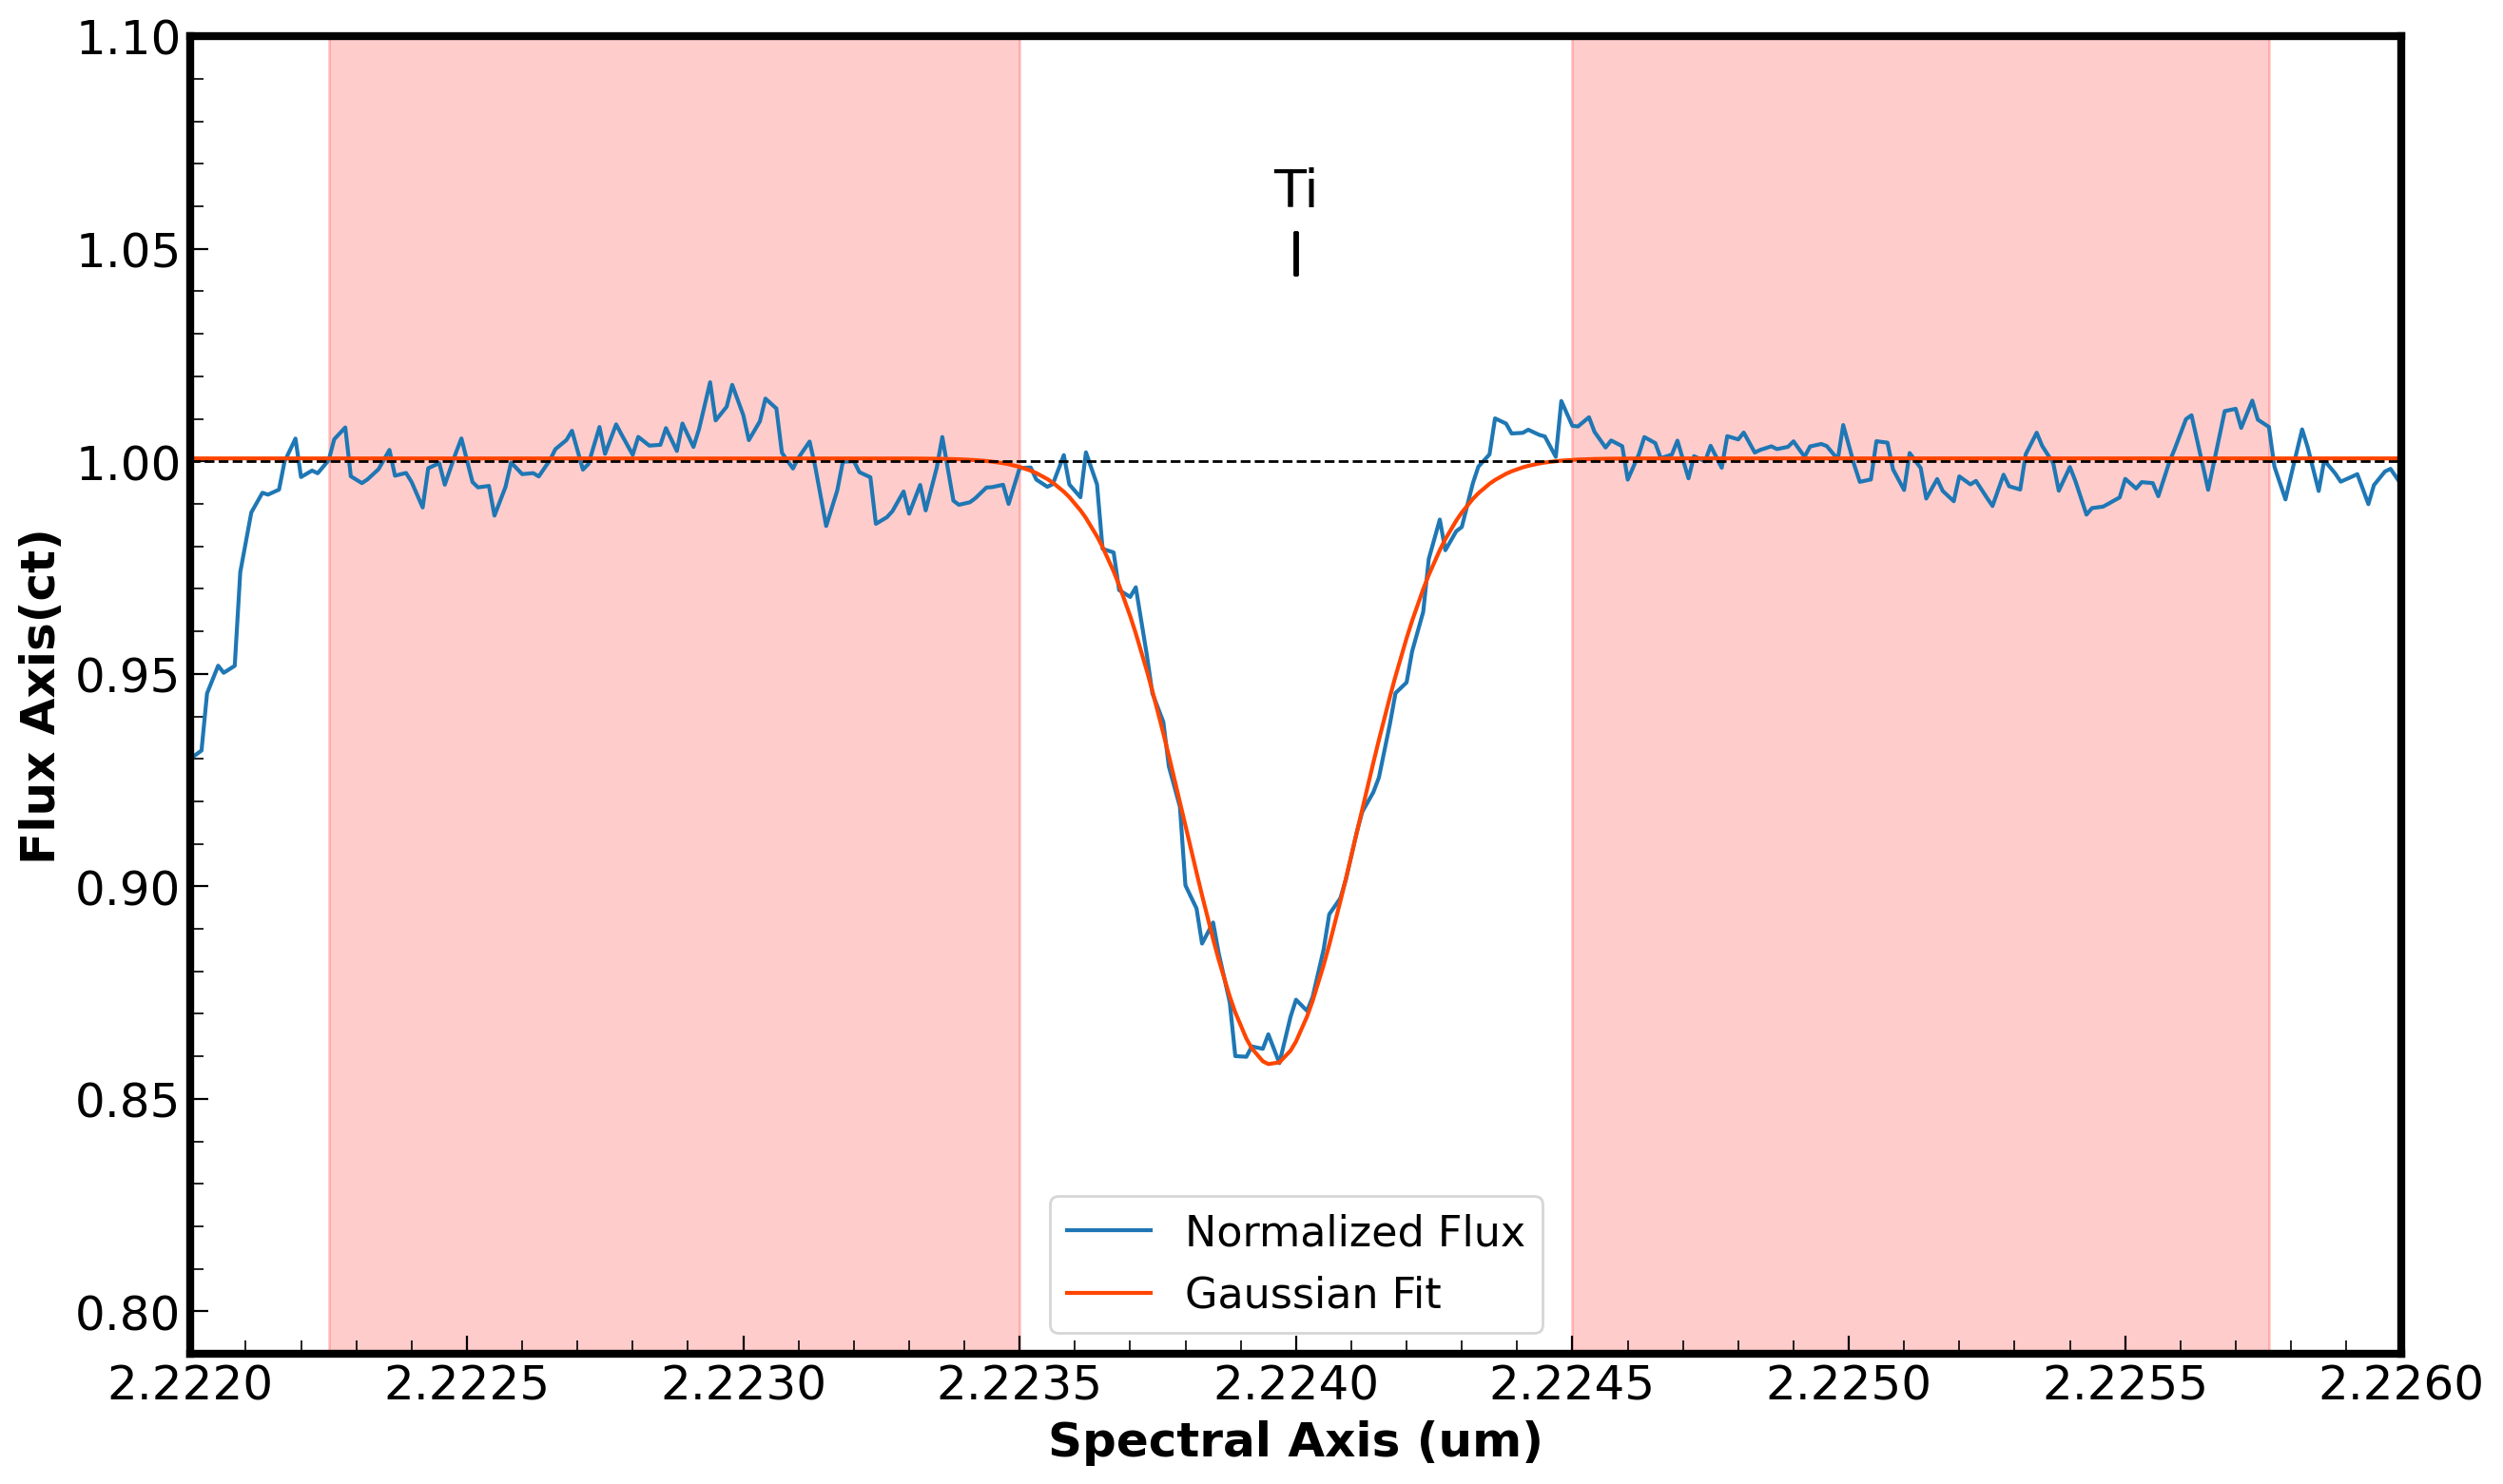

In [18]:
fig,ax = plt.subplots(figsize=(15,9))

# plt.scatter(anon1_spec.spectral_axis, anon1_spec.flux,label='Original Flux')
plt.plot(anon1_wavlen, cont_norm,label='Normalized Flux')
plt.plot(anon1_wavlen, best_model,color='orangered', label='Gaussian Fit')

# plt.fill_between(anon1_wavlen, y1=best_model, y2=1.0, where=(anon1_wavlen >= anon1_wavlen[contlo_max]) & (anon1_wavlen <= anon1_wavlen[conthi_min]), color='gray', alpha=0.5, label='Line Region')


plt.axhline(y=1, color='black', linewidth=1, linestyle='dashed')
# plt.axhline(y=half_max,color='black',lw=1,ls='dashed')
# plt.axvline(x=popt[1]+3*popt[2], color='black', linewidth=1, linestyle='dotted',label='3 $\sigma$')
# plt.axvline(x=popt[1]-3*popt[2], color='black', linewidth=1, linestyle='dotted')

# Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
# Iterate over number of objects
for i in range(len(nir_dict)):
    # Iterate over the NIR dictionary
    for ii in range(len(lines_wav)):
        plt.axvline(lines_wav[ii],0.82,0.85,color='black')
    # ax.text(lines_wav[ii],text_y,labels,ha='center')

# Continuum Estimation region
plt.axvspan(anon1_wavlen[contlo_min],anon1_wavlen[contlo_max], color='red', alpha=0.2)
plt.axvspan(anon1_wavlen[conthi_min],anon1_wavlen[conthi_max], color='red', alpha=0.2)

text_y = 1.06
ax.text(nir_dict['Ti-2.224'],text_y,'Ti',ha='center')

# Set fig axis limits
plt.xlim(2.222,2.226)
plt.ylim(0.79,1.1)

# Enable minor tick marks
ax.minorticks_on()

plt.xlabel('Spectral Axis ({})'.format(anon1_spec.spectral_axis.unit)) 
plt.ylabel('Flux Axis({})'.format(anon1_spec.flux.unit)) 
plt.legend()

plt.savefig(fig_path+'anon1_Ti_2_224_gauss.png')
plt.show()

# Equivalent Width !?

\begin{equation} W_\lambda = \int{\frac{F_c - F_s}{F_c}}d\lambda = \int (1- F_s/F_c) d\lambda \end{equation}

Finding the Equivalent Width:

Continuum level (1 from normalization, I think)

area of the feature (the fitted Gaussian?) : index of wavelengths where feature begins and ends

create a rectangle with that area, width of rectangle = EW 

## Questions
What unit should I report EW in? I see Angstrom everywhere I look

Should I require that the regions where I sample the continuum be equivalent in spectral resolution on either side of the line? I want to say it shouldn't matter because if there are features nearby then that makes life harder for me. In the case of anon1 here, there are the same width of 125 spectral elements.

Perhaps most importantly does the number I come up with make sense? I guess I'd have to check other lines first but it would be nice if I could get a sanity check here then I can just apply this approach to other lines and other sources at long last

Next to-do? Start taking ratios with other lines, how should I got about choosing which lines, just comparing lines between standards and sources?

In [19]:

# Flux at that central wavelength pixel
center_flux = best_model[center_idx]
print("Flux at Central Wavelength:", center_flux)

center_abs = 1-center_flux
print("Relative Absorption:", center_abs)


# Get FWHM
half_flux = 1-(center_abs/2)
print("Half Max Flux:", half_flux)

half_abs = center_abs/2
print("Half Relative Absorption:", half_abs)

# Need wavelengths where flux is at FWHM
# (best_model-half_max).abs().idxmin()


Flux at Central Wavelength: 0.8635132398441345
Relative Absorption: 0.13648676015586547
Half Max Flux: 0.9317566199220673
Half Relative Absorption: 0.06824338007793274


In [20]:
# The quick way to calculate the area
sigma = popt[2]
a = 1-cont_norm[center_idx]
(a * sigma * np.sqrt(2*np.pi))/(cont_norm[center_idx])

5.68053407731962e-05

# SciPy Integration

In [21]:
trapz(best_model,anon1_wavlen)

0.48263384343528415

In [22]:
# Using the continuum-normalized flux
resid_flux1 = 1 - (cont_norm)
# Integrating over wavelength range where I defined the spectral feature
ew1 = trapz(resid_flux1.loc[linemin_idx:linemax_idx], anon1_wavlen.loc[linemin_idx:linemax_idx])

print(f"Equivalent Width for Ti-2.224: {ew1:.6f}?")

Equivalent Width for Ti-2.224: 0.000053?


In [23]:
# Using the Gaussian fit
resid_flux2 = 1 - (best_model)
# Integrating over wavelength range where I defined the spectral feature
ew2 = trapz(resid_flux2.loc[linemin_idx:linemax_idx], anon1_wavlen.loc[linemin_idx:linemax_idx])

print(f"Equivalent Width for Ti-2.224: {ew2:.6f}")

Equivalent Width for Ti-2.224: 0.000055


In [24]:
# fig,ax = plt.subplots(figsize=(16,9))

# # plt.scatter(anon1_spec.spectral_axis, anon1_spec.flux,label='Original Flux')
# plt.plot(anon1_wavlen, cont_norm,label='Normalized Flux')
# plt.plot(anon1_wavlen, best_model,color='orangered', label='Gaussian Fit')

# plt.fill_between(anon1_wavlen, y1=best_model, y2=1.0, where=(anon1_wavlen >= anon1_wavlen[contlo_max]) & (anon1_wavlen <= anon1_wavlen[conthi_min]), color='gray', alpha=0.5, label='Line Region')


# plt.axhline(y=1, color='black', linewidth=1, linestyle='dashed')
# # plt.axhline(y=half_max,color='black',lw=1,ls='dashed')
# # plt.axvline(x=anon1_wavlen[wavemin_idx])

# # Draw equivalent width rectangle
# rect_width = ew1
# rect_height = 1-best_model[center_idx]

# rect_left = (wave_center - rect_width)
# rect_bottom = 0

# rectangle = patches.Rectangle((rect_left, rect_bottom), rect_width, rect_height, linewidth=1, edgecolor='r', facecolor='r')
# ax.add_patch(rectangle)

# # Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
# # Iterate over number of objects
# for i in range(len(nir_dict)):
#     # Iterate over the NIR dictionary
#     for ii in range(len(lines_wav)):
#         plt.axvline(lines_wav[ii],0.82,0.85,color='black')
#     # ax.text(lines_wav[ii],text_y,labels,ha='center')

# # Continuum Estimation region
# plt.axvspan(contlo_1,contlo_2, color='red', alpha=0.2)
# plt.axvspan(conthi_1,conthi_2, color='red', alpha=0.2)

# text_y = 1.06
# ax.text(nir_dict['Ti-2.224'],text_y,'Ti',ha='center')

# # Set fig axis limits
# plt.xlim(2.222,2.226)
# plt.ylim(0.8,1.1)

# # Enable minor tick marks
# ax.minorticks_on()

# plt.xlabel('Spectral Axis ({})'.format(anon1_spec.spectral_axis.unit)) 
# plt.ylabel('Flux Axis({})'.format(anon1_spec.flux.unit)) 
# plt.legend()

# plt.savefig(fig_path+'anon1_Ti_2_224_gauss.png')
# plt.show()

# Automating Line Identification at some point?
Want to fit a local continuum to get equivalent widths

In [25]:
noise_region = SpectralRegion(0*u.um, 3*u.um)

spectrum = noise_region_uncertainty(anon1_spec, noise_region)


lines = find_lines_threshold(spectrum, noise_factor=3)  

lines[lines['line_type'] == 'emission']



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
um,,
float64,str8,int64
2.0079,emission,411
2.37217,emission,25118
2.38322,emission,25848
2.40767,emission,27298
2.4144101,emission,27736
2.41448,emission,27741
2.4193101,emission,28001
2.4458201,emission,29534
